In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as dd
import pandas as pd
import networkx as nx
import networkx.algorithms.approximation

In [2]:
FOLDER = 'E:/diss/reuters/'

In [35]:
LBLTYPE = 3
COMPNAME = 0
NCD_FORMULA = "norm-inf-dist-1"

In [4]:
seqs = dd.read_csv(FOLDER + "seqs.csv").set_index("seqid")
seqs.head(5)

,seqpart,seq
seqid,,
0,1,[CLS] asian export ##ers fear damage from u . ...
1,2,[CLS] china daily says ve ##rmin eat 7 - 12 pc...
2,1,[CLS] japan to rev ##ise long - term energy de...
3,2,[CLS] thai trade deficit widen ##s in first qu...
4,1,[CLS] indonesia sees cp ##o price rising sharp...


In [36]:
lbls = pd.read_csv(FOLDER + "labels.csv")
lbls = { row["seqid"] : row["lbl"] for index, row in lbls[lbls["lbltype"] == LBLTYPE].iterrows() }

In [11]:
df = dd.read_csv(FOLDER + "graphs.csv")
df = df[(df["compid"] == COMPNAME) & (df["ncd_formula"] == NCD_FORMULA) & (df["seqpart"] == 1)].compute()

In [12]:
df

,compid,ncd_formula,dist_aggregator,seqpart,seqid_1,seqid_2,seqid_train,dist
1143566,0,norm-inf-dist-1,mp,1,0,2,3976,1.804914
1143567,0,norm-inf-dist-1,mp,1,2,0,3976,1.804914
1143568,0,norm-inf-dist-1,mp,1,0,4,3325,1.799317
1143569,0,norm-inf-dist-1,mp,1,4,0,3325,1.799317
1143570,0,norm-inf-dist-1,mp,1,0,6,3459,1.831853
...,...,...,...,...,...,...,...,...
834713,0,norm-inf-dist-1,mp,1,3016,3014,7051,1.682795
834714,0,norm-inf-dist-1,mp,1,3014,3018,3063,1.658857
834715,0,norm-inf-dist-1,mp,1,3018,3014,3063,1.658857
834718,0,norm-inf-dist-1,mp,1,3016,3018,7051,1.512498


### Spectral analysis

In [13]:
n_points = df["seqid_1"].nunique()
NCD = np.zeros((n_points, n_points))
seqids = list(df["seqid_1"].unique())
seqids = dict(map(lambda ij: (ij[1], ij[0]), enumerate(seqids)))
for index, row in df.iterrows():
    i, j = seqids[row["seqid_1"]], seqids[row["seqid_2"]]
    NCD[i, j] = row["dist"]

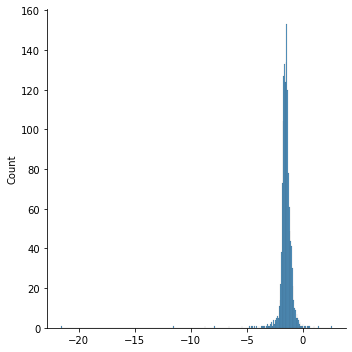

Largest eigenvalue was 2331.0647468398115 (not shown).


In [14]:
ncd_eigs, ncd_eigvs = np.linalg.eigh(NCD)
sns.displot(ncd_eigs[:-1])  # don't show last eigenvalue, ruins the scale
plt.show()
print("Largest eigenvalue was", ncd_eigs[-1], "(not shown).")

In [15]:
n_repeats, n_dim = 100, 10

null_eigs = np.zeros((n_repeats, n_points))
for i in range(n_repeats):
    X = np.random.random((n_points, n_dim))
    D = np.sum(np.abs(X[:, np.newaxis, :] - X[np.newaxis, :, :]), axis=-1)
    assert(D.shape == (n_points, n_points))
    null_eigs[i, :] = np.linalg.eigvalsh(D)

Bulk


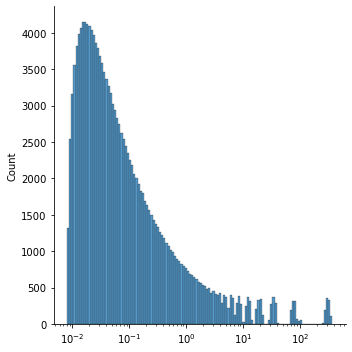

Largest


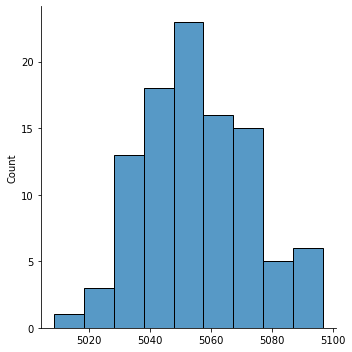

In [16]:
print('Bulk')
sns.displot((-null_eigs[:, :-1]).flatten(), log_scale=True)  # don't show last eigenvalue, ruins the scale
plt.show()
print('Largest')
sns.displot(null_eigs[:, -1])
plt.show()

### Most Negative NCD Eigenvector Analysis

In [20]:
eig_idx = 0
df_eig = pd.DataFrame([
    (seqid, ncd_eigvs[eig_idx, seqids[seqid]], lbls[seqid], seqs.loc[seqid]["seq"].compute().values[0])
    for seqid in df["seqid_1"].unique()
], columns=["seqid", "eigv", "lbl", "seq"])
df_eig

,seqid,eigv,lbl,seq
0,0,0.044386,0,[CLS] asian export ##ers fear damage from u . ...
1,2,-0.021847,0,[CLS] japan to rev ##ise long - term energy de...
2,4,0.013013,0,[CLS] indonesia sees cp ##o price rising sharp...
3,6,-0.026142,0,[CLS] indonesian commodity exchange may expand...
4,8,0.009066,0,[CLS] western mining to open new gold mine in ...
...,...,...,...,...
1505,3010,0.005937,0,[CLS] new zealand impose ##s sanctions against...
1506,3012,-0.003829,0,"[CLS] iran , soviet union to swap crude , refi..."
1507,3014,0.000391,1,[CLS] n . z . ' s chase corp makes offer for e...
1508,3016,-0.003003,0,[CLS] japan / india conference cuts gulf war r...


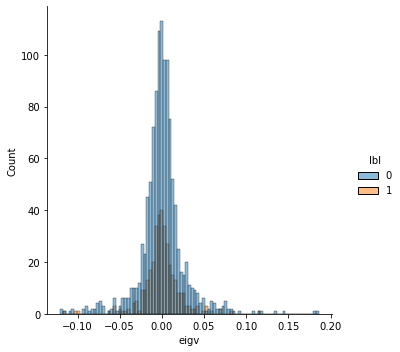

In [21]:
sns.displot(df_eig, x="eigv", hue="lbl")
plt.show()

### Label Analysis

In [37]:
n_repeats = 100
y_true, y_randoms = np.zeros((n_points,)), np.zeros((n_repeats, n_points))
for seqid, idx in seqids.items():
    y_true[idx] = (1.0 if lbls[seqid] == 1 else -1.0)
for i in range(n_repeats):
    y_randoms[i] = y_true
    np.random.shuffle(y_randoms[i])

In [38]:
G = nx.from_numpy_array(NCD)
true_score = nx.cut_size(G, np.argwhere(y_true == 1)[:, 0], weight='weight')
null_score_dist = [nx.cut_size(G, np.argwhere(y_randoms[i] == 1)[:, 0], weight='weight') for i in range(n_repeats)]

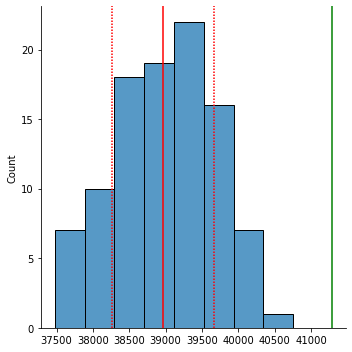

In [39]:
sns.displot(null_score_dist)
plt.axvline(x=true_score, color='green')
plt.axvline(x=np.mean(null_score_dist), color='red')
plt.axvline(x=np.mean(null_score_dist) + np.std(null_score_dist), color='red', dashes=(1.0, 1.0))
plt.axvline(x=np.mean(null_score_dist) - np.std(null_score_dist), color='red', dashes=(1.0, 1.0))
plt.show()